In [1]:
%matplotlib inline
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [2]:
# read the data
steven = pd.read_csv('stevens.csv')

# split the data into features and respond
features = ['Circuit','Issue','Petitioner','Respondent','LowerCourt','Unconst']
responds = ['Reverse']
X = steven[features]
Y = steven[responds]

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 6 columns):
Circuit       566 non-null object
Issue         566 non-null object
Petitioner    566 non-null object
Respondent    566 non-null object
LowerCourt    566 non-null object
Unconst       566 non-null int64
dtypes: int64(1), object(5)
memory usage: 26.6+ KB


In [4]:
# identify the categorical data
#categorical = ['Circuit','Issue','Petitioner','Respondent','LowerCourt']
categorical = ['Issue','LowerCourt']
X_encoded = pd.DataFrame()

for item in categorical:
    #encoder that transforms string into label
    label_coder = LabelEncoder()
    label = label_coder.fit_transform(X[item])
    #encoder that transforms label into multiple columns
    onehot_coder = OneHotEncoder(sparse=False)
    a = onehot_coder.fit_transform(label.reshape(-1,1))
    new_a = pd.DataFrame(a,columns=item + " : " + label_coder.classes_)
    for col in new_a:
        X_encoded[col] = new_a[col]
        
# identify the numerical data
numerical = []

for item in numerical:
    X_encoded[item] = X[item]

In [5]:
# spliting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_encoded,
                                                    Y,
                                                    random_state = 0, 
                                                    test_size = 0.3,
                                                    stratify = Y.Reverse)

# model training
model = DecisionTreeClassifier(min_samples_leaf = 10,criterion='entropy',min_impurity_decrease=0.0007)
model.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0007, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

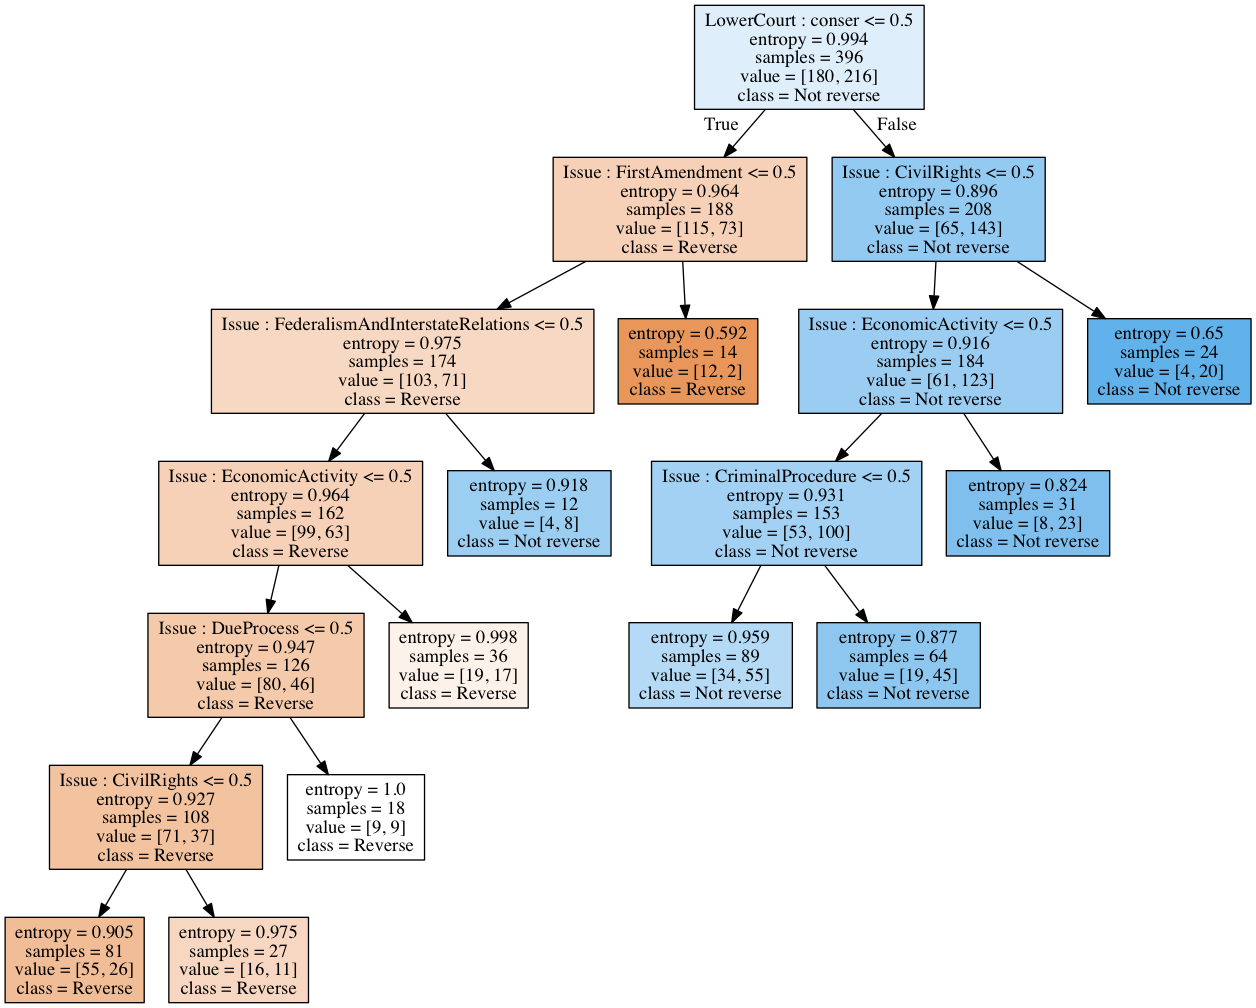

In [6]:
# export the decision tree graph
export_graphviz(model,out_file='steven.dot',
                feature_names=X_train.columns,
                class_names = ['Reverse','Not reverse'],
               leaves_parallel=False,
               filled = True)

!dot -Tpng steven.dot -o tree.png
Image('tree.png')

In [7]:
# confusion matrix
Y_predict = model.predict(X_test)
confusion = confusion_matrix(Y_test, Y_predict)
print('Confusion matrix:\n',confusion)
print('Accuracy:',(confusion[0,0] + confusion[1,1]) / sum(sum(confusion)))

Confusion matrix:
 [[52 25]
 [29 64]]
Accuracy: 0.682352941176


FPR:  [ 0.          0.32467532  1.        ]
TPR:  [ 0.          0.32467532  1.        ]
Threshold:  [2 1 0]
AUC:  0.681748359168


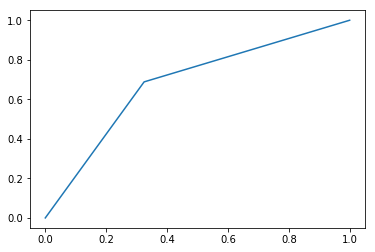

In [9]:
# using simple binary responds
fpr, tpr, threshold = roc_curve(Y_test, Y_predict)

print('FPR: ', fpr)
print('TPR: ', fpr)
print('Threshold: ', threshold)

print('AUC: ', roc_auc_score(Y_test, Y_predict))

plt.plot(fpr,tpr)

FPR:  [ 0.          0.01298701  0.05194805  0.12987013  0.18181818  0.32467532
  0.35064935  0.49350649  0.5974026   0.93506494  1.        ]
TPR:  [ 0.          0.01298701  0.05194805  0.12987013  0.18181818  0.32467532
  0.35064935  0.49350649  0.5974026   0.93506494  1.        ]
Threshold:  [ 1.83333333  0.83333333  0.74193548  0.703125    0.66666667  0.61797753
  0.5         0.47222222  0.40740741  0.32098765  0.14285714]
AUC:  0.698296327329


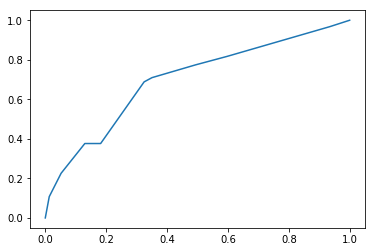

In [11]:
# using probability responds
Y_predprob = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(Y_test, Y_predprob[:,1])

print('FPR: ', fpr)
print('TPR: ', fpr)
print('Threshold: ', threshold)

print('AUC: ', roc_auc_score(Y_test, Y_predprob[:, 1]))
plt.plot(fpr,tpr)

# Implementing a multi-way split decision tree model applicable to categorical data
Comparing with the one in Scikit-learn, this model can have deal with categorical data. It will also have multiple splits in each node. 

In [16]:
from catedecisiontree import *
%load_ext autoreload
%autoreload catedecisiontree

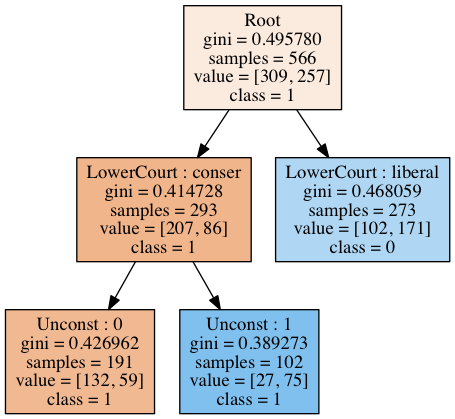

In [13]:
# split the data into features and respond
#features = ['Circuit','Issue','Petitioner','Respondent','LowerCourt','Unconst']
features = ['Unconst','LowerCourt']
responds = ['Reverse']
X = steven[features]
Y = steven[responds]
node = TreeGenerate(X, Y, features, gini_decrease_min=0.0001)
export_graph(node, 'test.dot',filled = True)
!dot -Tpng test.dot -o test.png
Image('test.png')

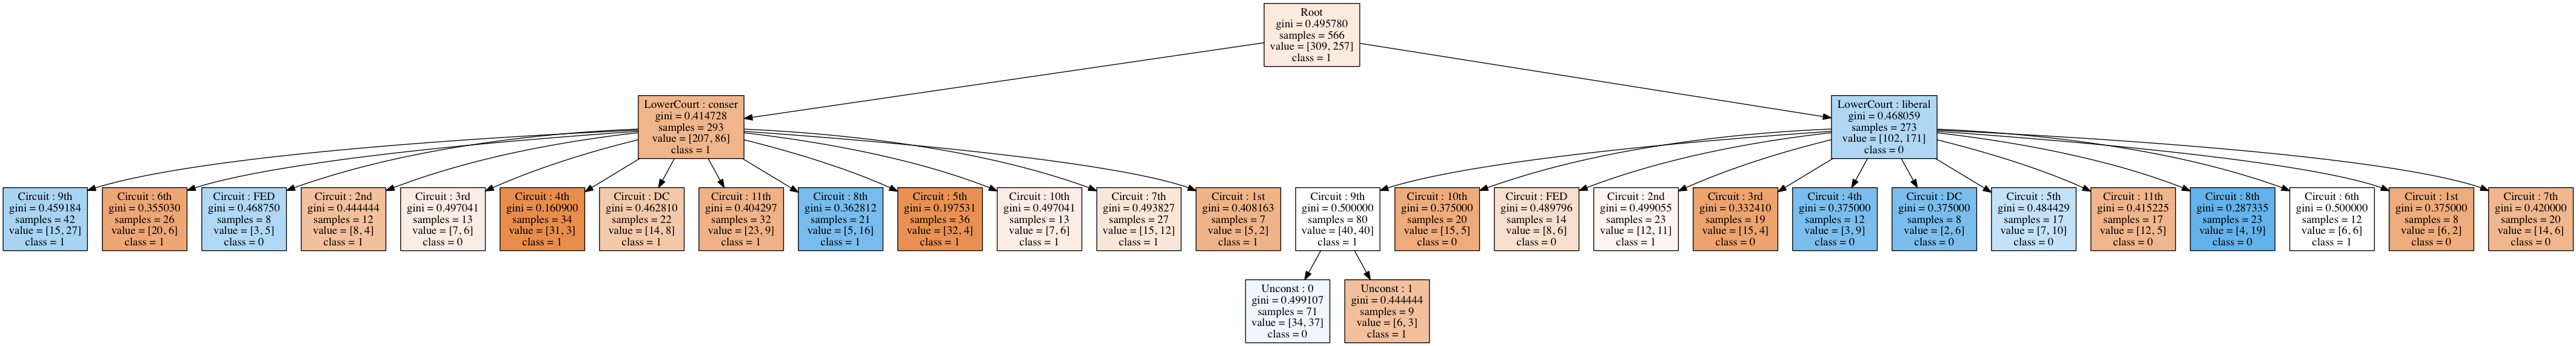

In [14]:
# split the data into features and respond
#features = ['Circuit','Issue','Petitioner','Respondent','LowerCourt','Unconst']
features = ['Unconst','LowerCourt', 'Circuit']
responds = ['Reverse']
X = steven[features]
Y = steven[responds]
node = TreeGenerate(X, Y, features, min_split=60, gini_decrease_min=0.0001)
export_graph(node, 'test.dot',filled = True)
!dot -Tpng test.dot -o test.png
Image('test.png')

# Implementing a binary split decision tree applicable to categorical data
This is essentially an expenentially expensive way. Because we need to consider $2^n-1$ number of splits. Here we only consider the binary classification problem. Details can be found in https://www.mathworks.com/help/stats/splitting-categorical-predictors-for-multiclass-classification.html.

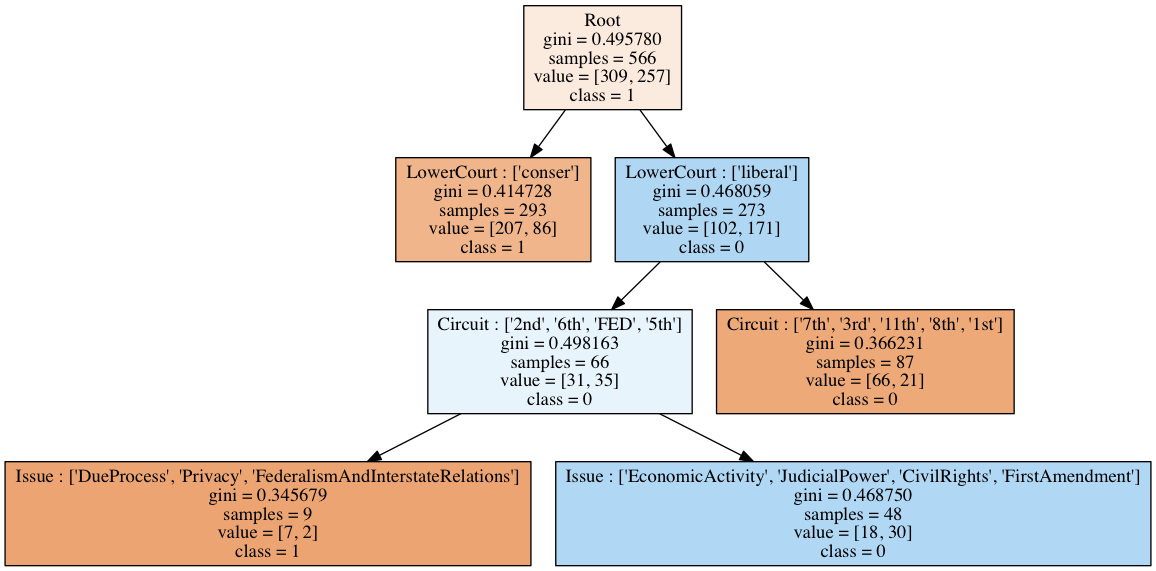

In [15]:
features = ['Circuit','Issue','Petitioner','Respondent','LowerCourt','Unconst']
#features = ['Unconst','LowerCourt']
responds = ['Reverse']
X = steven[features]
Y = steven[responds]
node = TreeGenerate(X, Y, features,split = 'binary', gini_decrease_min = 0.028)
export_graph(node, 'test.dot',filled = True)
!dot -Tpng test.dot -o testbinary.png
Image('testbinary.png')